In [31]:
### packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import datetime
import time
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_absolute_error

In [32]:
### Read CSV data
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 1, 1)
numberofdates=start-end
print(numberofdates)
stocks = '000001.SS'
SSE = yf.download(stocks,start=start, end=end, interval='1d')
SSE.head()

[*********************100%%**********************]  1 of 1 completed

-4748 days, 0:00:00


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,3289.750000,3295.279053,3243.319092,3243.760010,3243.760010,109400
2010-01-05,3254.468018,3290.511963,3221.461914,3282.178955,3282.178955,126200
2010-01-06,3277.517090,3295.867920,3253.043945,3254.215088,3254.215088,123600
2010-01-07,3253.990967,3268.819092,3176.707031,3192.775879,3192.775879,128600
2010-01-08,3177.259033,3198.919922,3149.017090,3195.997070,3195.997070,98400


[*********************100%%**********************]  1 of 1 completed

                   Min            Max        Average             SD
Open       1935.515991    5174.417969    2911.668996     523.720820
High       1959.157959    5178.190918    2934.019622     529.510988
Low        1849.652954    5103.400879    2889.601953     515.993472
Close      1950.011963    5166.350098    2914.539374     524.066127
Adj Close  1950.011963    5166.350098    2914.539374     524.066127
Volume      100.000000  857100.000000  205401.362916  130851.867149


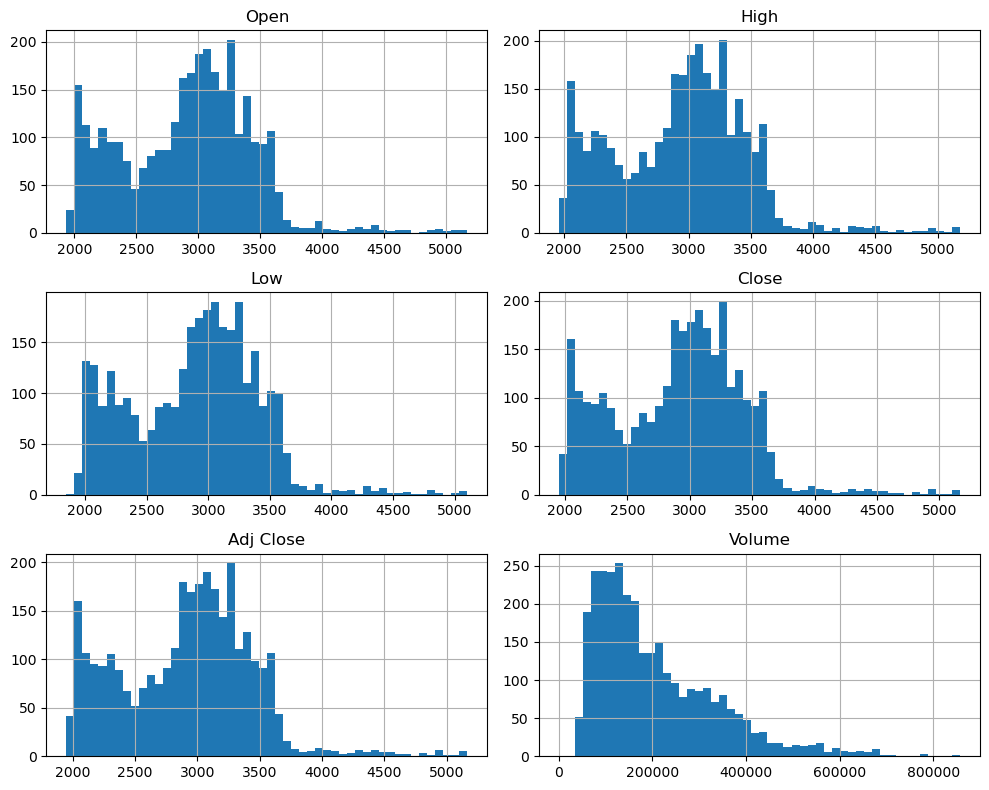

In [33]:
ticker = '000001.SS'  # Shanghai Stock Exchange Index
data = yf.download(ticker, start=start, end=end)

# Calculate summary statistics
summary_stats = data.describe().T[['min', 'max', 'mean', 'std']]

# Rename the columns appropriately
summary_stats.columns = ['Min', 'Max', 'Average', 'SD']

# Display summary statistics
print(summary_stats)

# Create histograms for all variables
data.hist(bins=50, figsize=(10, 8), layout=(3,2))
plt.tight_layout()
plt.show()

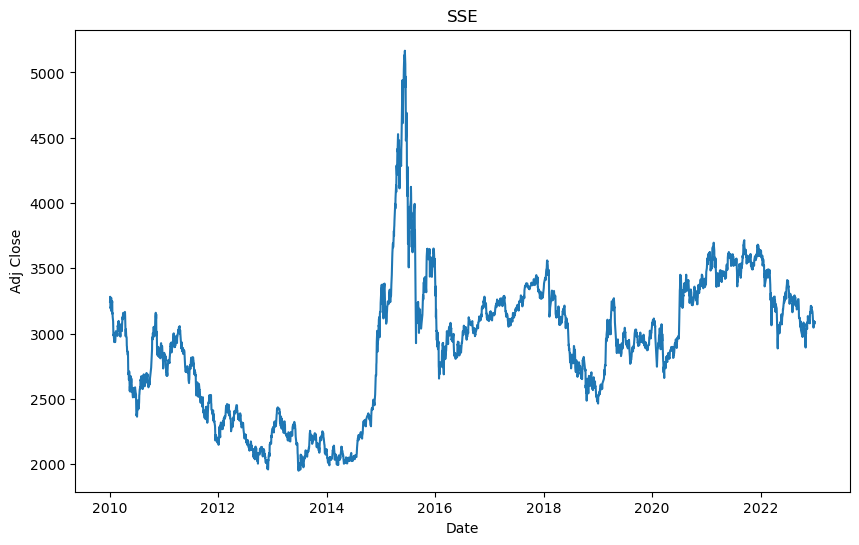

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(SSE.index,SSE['Adj Close'])
plt.title('SSE')
plt.ylabel('Adj Close')
plt.xlabel('Date')
plt.show()

In [35]:
### p-value &ADF test
print("p-value:%f" % adfuller(SSE["Adj Close"])[1])

p-value:0.152294


As the p-value is greater than level of significance, we fail to reject the null that a unit root is present in this time series.

In [36]:
returns = 100* SSE["Adj Close"].pct_change().dropna()

In [37]:
### p-value &ADF test
print("stock price ADF Statistic:%f" % adfuller(SSE["Adj Close"])[0])
print("stock price ADF p-value:%f" % adfuller(SSE["Adj Close"])[1])
print("stock returns ADF statistics:%f" % adfuller(returns)[0])
print("stock returns ADF p-value:%f" % adfuller(returns)[1])

stock price ADF Statistic:-2.363536
stock price ADF p-value:0.152294
stock returns ADF statistics:-10.519630
stock returns ADF p-value:0.000000


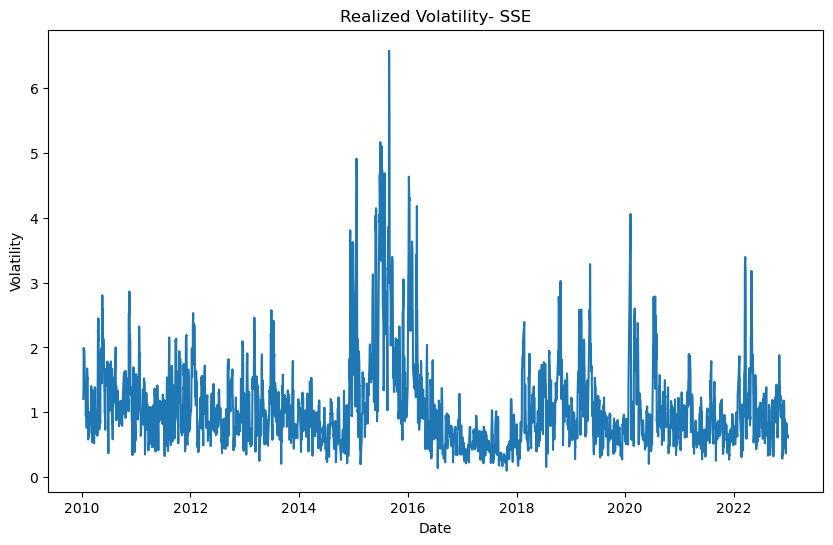

In [38]:
#graph returns
realized_vol = returns.rolling(5).std().dropna()
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- SSE')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

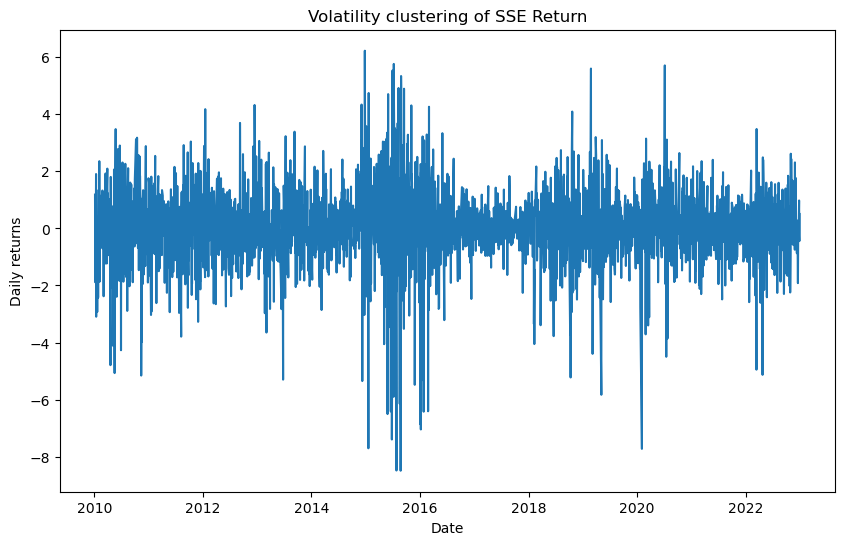

In [39]:
#graph volatility
plt.figure(figsize=(10, 6))
plt.plot(SSE.index[1:],returns)
plt.title('Volatility clustering of SSE Return')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

In [40]:
# Select the best arch model
n = 4748
split_date = returns.iloc[-n:].index

bic_arch = []
for p in range(1, 3):
        arch = arch_model(returns, mean='zero',vol='ARCH', p=p)\
            .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param_arch = p
arch = arch_model(returns, mean='zero', vol='ARCH',p=best_param_arch)\
            .fit(disp='off')
print(arch.summary())
forecast_arch = arch.forecast(start=split_date[0])
print(forecast_arch)

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5105.75
Distribution:                  Normal   AIC:                           10217.5
Method:            Maximum Likelihood   BIC:                           10235.7
                                        No. Observations:                 3154
Date:                Mon, Apr 22 2024   Df Residuals:                     3154
Time:                        21:16:10   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.0080  6.357e-02     15.857  1.248e-56   [  0.88

In [41]:
# Select the best garch model
bic_garch = []
for p in range(1, 3):
    for q in range(1, 3):
        garch = arch_model(returns, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param_garch = p, q
garch = arch_model(returns, mean='zero', vol='GARCH',p=best_param_garch[0], o=0, q=best_param_garch[1])\
            .fit(disp='off')
print(garch.summary())
forecast_garch = garch.forecast(start=split_date[0])
print(forecast_garch)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4905.46
Distribution:                  Normal   AIC:                           9816.92
Method:            Maximum Likelihood   BIC:                           9835.09
                                        No. Observations:                 3154
Date:                Mon, Apr 22 2024   Df Residuals:                     3154
Time:                        21:16:10   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0135  6.658e-03      2.026  4.271e-02 [4.

The best model selected is ARCH(2) and GARCH(1,1). Using AIC and BIC as our model selection criterion, GARCH(1,1) seems to be a even better model as it minimize aic and bic.

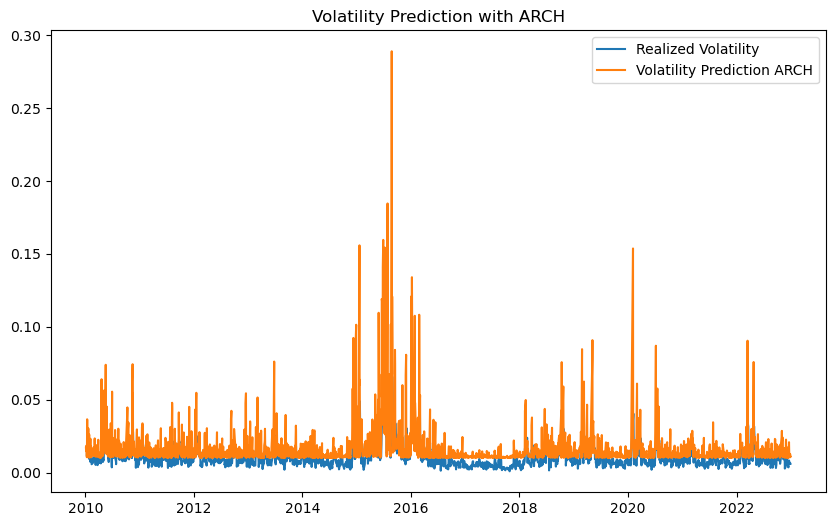

In [42]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()

In [43]:
forecasted_volatility_arch = np.sqrt(forecast_arch.variance.dropna())
forecasted_volatility_aligned_arch = forecasted_volatility_arch.loc[realized_vol.index]
rmse_arch = np.sqrt(mean_squared_error(realized_vol, forecasted_volatility_aligned_arch))
print('RMSE for ARCH:', rmse_arch)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_actuals = y_true != 0
    return np.mean(np.abs((y_true[non_zero_actuals] - y_pred[non_zero_actuals]) / y_true[non_zero_actuals])) * 100

mape_arch = mean_absolute_percentage_error(realized_vol, forecasted_volatility_aligned_arch)
print(f'MAPE for ARCH: {mape_arch:.2f}%')

RMSE for ARCH: 0.5266746065269503
MAPE for ARCH: 77.19%


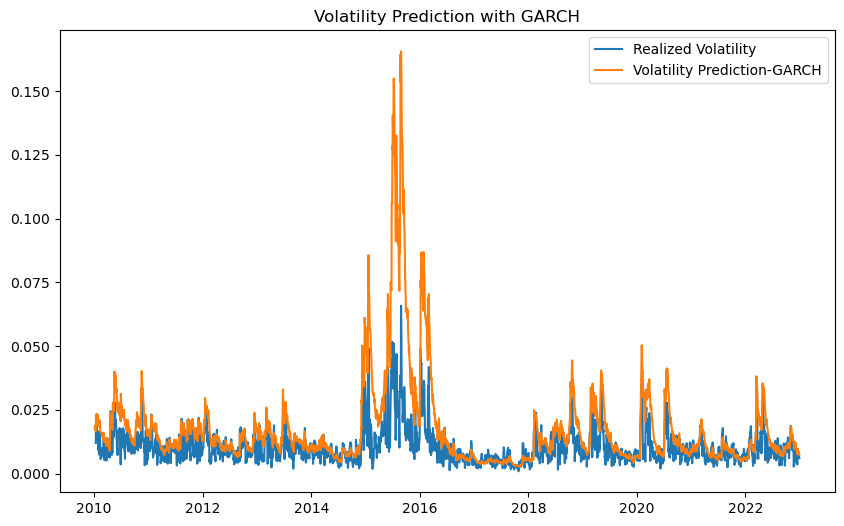

In [44]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()

In [45]:
# Calculate forecasted volatility (square root of variance forecasts)
forecasted_volatility_garch = np.sqrt(forecast_garch.variance.dropna())
forecasted_volatility_aligned_garch = forecasted_volatility_garch.loc[realized_vol.index]
rmse_garch = np.sqrt(mean_squared_error(realized_vol, forecasted_volatility_aligned_garch))
print('RMSE for GARCH:', rmse_garch)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_actuals = y_true != 0
    return np.mean(np.abs((y_true[non_zero_actuals] - y_pred[non_zero_actuals]) / y_true[non_zero_actuals])) * 100

mape_garch = mean_absolute_percentage_error(realized_vol, forecasted_volatility_aligned_garch)
print(f'MAPE for GARCH: {mape_garch:.2f}%')

RMSE for GARCH: 0.43502980161757493
MAPE for GARCH: 78.75%


# ARMA-GARCH

In [46]:
# Select the best garch model
bic_armagarch = []
for p in range(1, 3):
    for q in range(1, 3):
        armagarch = arch_model(returns, mean='AR',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_armagarch.append(armagarch.bic)
        if armagarch.bic == np.min(bic_armagarch):
            best_param_armagarch = p, q
armagarch = arch_model(returns, mean='AR', vol='GARCH',p=best_param_armagarch[0], o=0, q=best_param_armagarch[1])\
            .fit(disp='off')
print(armagarch.summary())
forecast_armagarch = armagarch.forecast(start=split_date[0])
print(forecast_armagarch)

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4905.24
Distribution:                  Normal   AIC:                           9818.47
Method:            Maximum Likelihood   BIC:                           9842.70
                                        No. Observations:                 3154
Date:                Mon, Apr 22 2024   Df Residuals:                     3153
Time:                        21:16:13   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0120  1.802e-02      0.666      0.505 

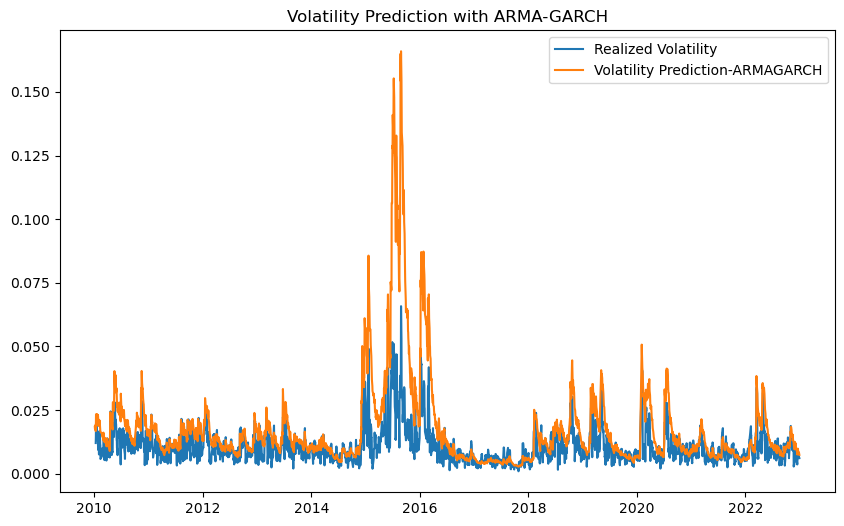

In [47]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_armagarch.variance.iloc[-len(split_date):] / 100,
                  label='Volatility Prediction-ARMAGARCH')
plt.title('Volatility Prediction with ARMA-GARCH', fontsize=12)
plt.legend()

In [48]:
# Calculate forecasted volatility (square root of variance forecasts)
forecasted_volatility_armaarch = np.sqrt(forecast_armagarch.variance.dropna())
forecasted_volatility_aligned_armagarch = forecasted_volatility_armaarch.loc[realized_vol.index]
rmse_armagarch = np.sqrt(mean_squared_error(realized_vol, forecasted_volatility_aligned_armaarch))
print('RMSE for ARMAGARCH:', rmse_armagarch)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_actuals = y_true != 0
    return np.mean(np.abs((y_true[non_zero_actuals] - y_pred[non_zero_actuals]) / y_true[non_zero_actuals])) * 100

mape_arma = mean_absolute_percentage_error(realized_vol, forecasted_volatility_aligned_armagarch)
print(f'MAPE for ARMAGARCH: {mape_arma:.2f}%')

NameError: name 'forecasted_volatility_aligned_armaarch' is not defined

# What if we train GARCH

In [49]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from arch import arch_model
from sklearn.metrics import mean_squared_error

# Assuming SSE is your DataFrame with stock data
returns = 100 * SSE["Adj Close"].pct_change().dropna()
realized_vol = returns.rolling(5).std().dropna()

# Assuming 'returns' is your DataFrame column of daily returns
train_size = int(len(returns) * 0.8)  # 80% of data for training
returns_train = returns[:train_size]
returns_test = returns[train_size:]

# Step 2: Fit the GARCH Model on Training Data
train_garch_model = arch_model(returns_train, mean='Zero', vol='Garch', p=1, q=1)
train_garch_fit = train_garch_model.fit(disp='off')

# Step 3: Rolling Forecast for Testing Period
predicted_volatility_trained = pd.Series(index=returns_test.index)

for end_date in returns_test.index:
    # Update the model with data up to the end date
    current_data = returns[:end_date]
    model = arch_model(current_data, mean='Zero', vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off', last_obs=end_date)
    
    # Forecast the next day's volatility
    forecast = model_fit.forecast(horizon=1)
    next_day_volatility = np.sqrt(forecast.variance.iloc[-1]).values[0]
    
    # Store the forecast
    predicted_volatility_trained.loc[end_date] = next_day_volatility

# Step 4: Plot Actual vs. Predicted Volatility
# Calculate actual rolling volatility for the test set
actual_volatility_test = returns_test.rolling(window=5).std()


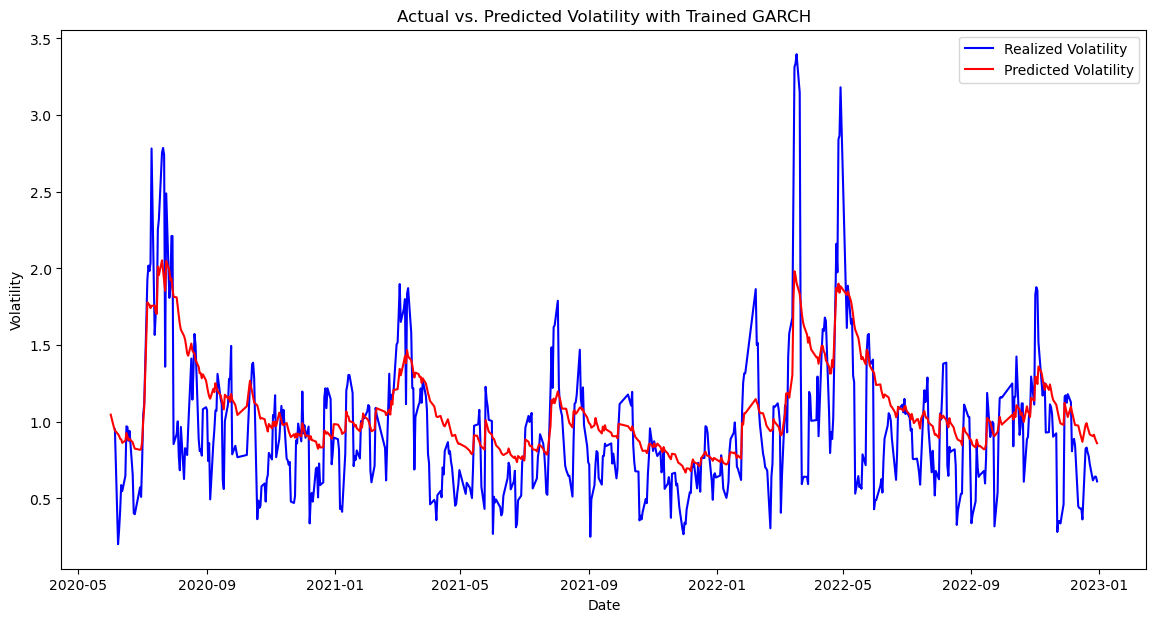

In [50]:
# Calculate actual rolling volatility for the test set
plt.figure(figsize=(14, 7))
plt.plot(actual_volatility_test, label='Realized Volatility', color='blue')
plt.plot(predicted_volatility_trained, label='Predicted Volatility', color='red')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Actual vs. Predicted Volatility with Trained GARCH')
plt.legend()
plt.show()

 # SVR-GARCH

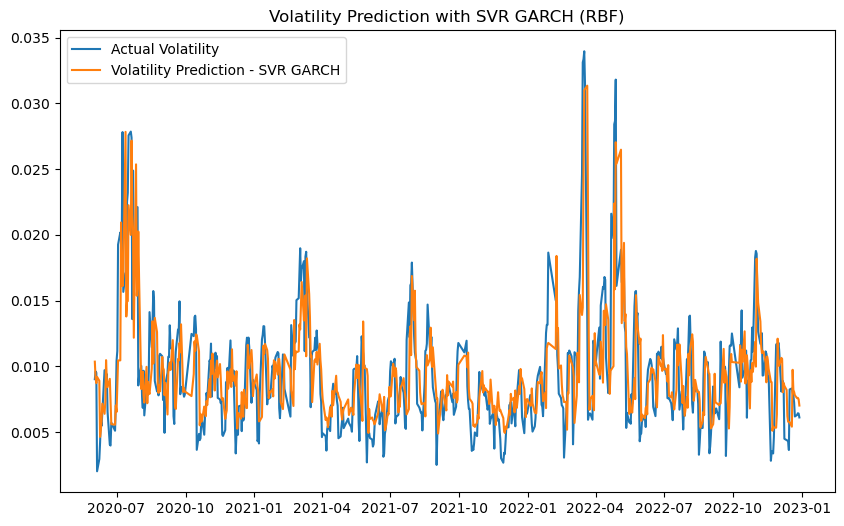

In [90]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

# Calculate returns
ret = 100 * SSE['Adj Close'].pct_change().dropna()

# Calculate the rolling mean of returns and residuals
mean_returns = ret.rolling(window=5).mean()
residuals = ret - mean_returns

# Calculate realized volatility and squared residuals
realized_vol = ret.rolling(5).std().dropna()
squared_residuals = residuals**2

# Ensure all series are aligned and have the same length
lagged_vol = realized_vol.shift(1)
lagged_residuals = squared_residuals.shift(1)

# Create the feature DataFrame
X = pd.DataFrame({
    'lagged_volatility': lagged_vol,
    'lagged_squared_residuals': lagged_residuals
})

# Drop any rows with NaN values which might have been introduced by shifting
X.dropna(inplace=True)

# The target variable: next day's realized volatility, aligned with X
y = realized_vol.shift(-1)
y = y.reindex(X.index).dropna()

# Ensure X and y have exactly the same index to avoid 'KeyError'
X = X.loc[y.index]

# Split the data into training and test sets
n = int(len(X) * 0.2)
X_train, X_test = X.iloc[:-n], X.iloc[-n:]
y_train, y_test = y.iloc[:-n], y.iloc[-n:]

# Define the SVR with RBF kernel
svr_rbf = SVR(kernel='rbf')

# Parameter grid for RandomizedSearchCV
param_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}

# Perform the Randomized Search with the RBF SVR model
clf = RandomizedSearchCV(svr_rbf, param_grid, random_state=42)
clf.fit(X_train, y_train)

# Make predictions for the last n observations
predict_svr_rbf = clf.predict(X_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test / 100, label='Actual Volatility')
plt.plot(y_test.index, pd.Series(predict_svr_rbf, index=y_test.index) / 100, label='Volatility Prediction - SVR GARCH')
plt.title('Volatility Prediction with SVR GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predict_svr_rbf))
print(f'RMSE: {rmse:.4f}')

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, predict_svr_rbf)
print(f'MAPE: {mape:.4%}')  # Converts to percentage format

RMSE: 0.3327
MAPE: 29.1875%


Optimal Parameters: {'C': 0.5986584841970366, 'epsilon': 0.15601864044243652, 'gamma': 0.15599452033620265}


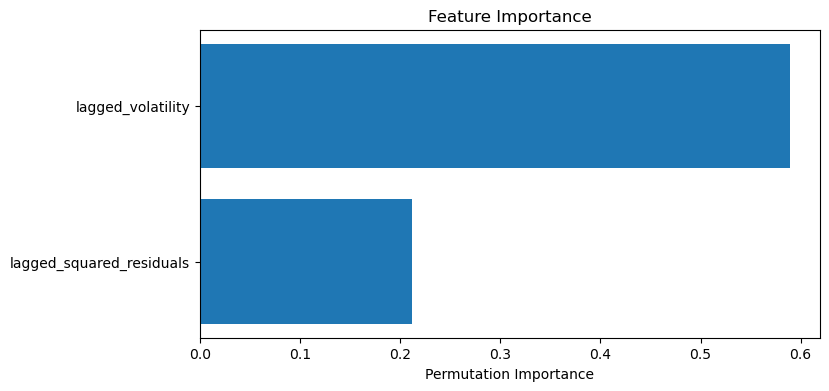

In [86]:
from sklearn.inspection import permutation_importance
best_parameters = clf.best_params_
print(f"Optimal Parameters: {best_parameters}")
from sklearn.inspection import permutation_importance

# Perform permutation importance
perm_importance = permutation_importance(clf.best_estimator_, X_test, y_test, n_repeats=10, random_state=42)

# Organize and plot the results
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 4))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

# Random Forest

RMSE: 0.0028721331949975713
MAPE: 25.35%


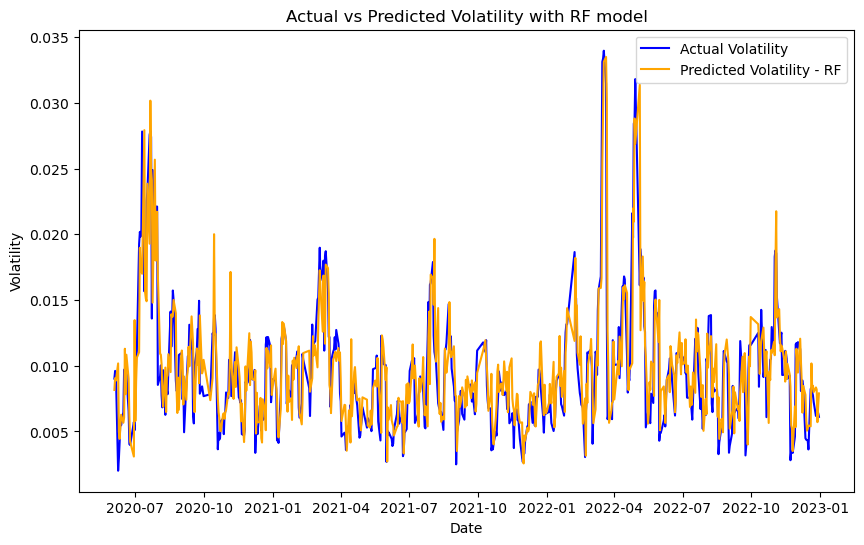

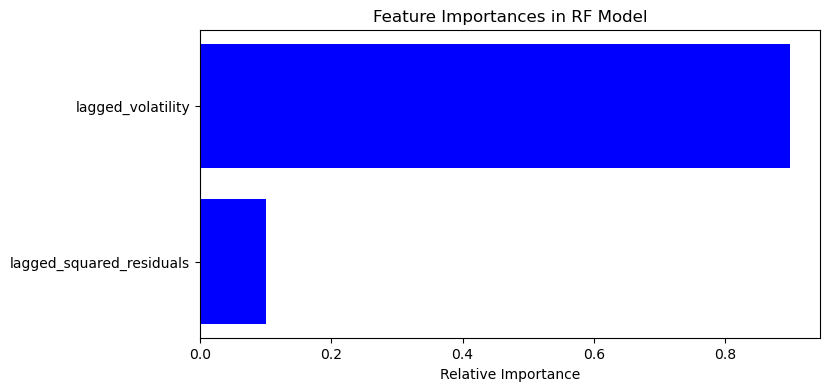

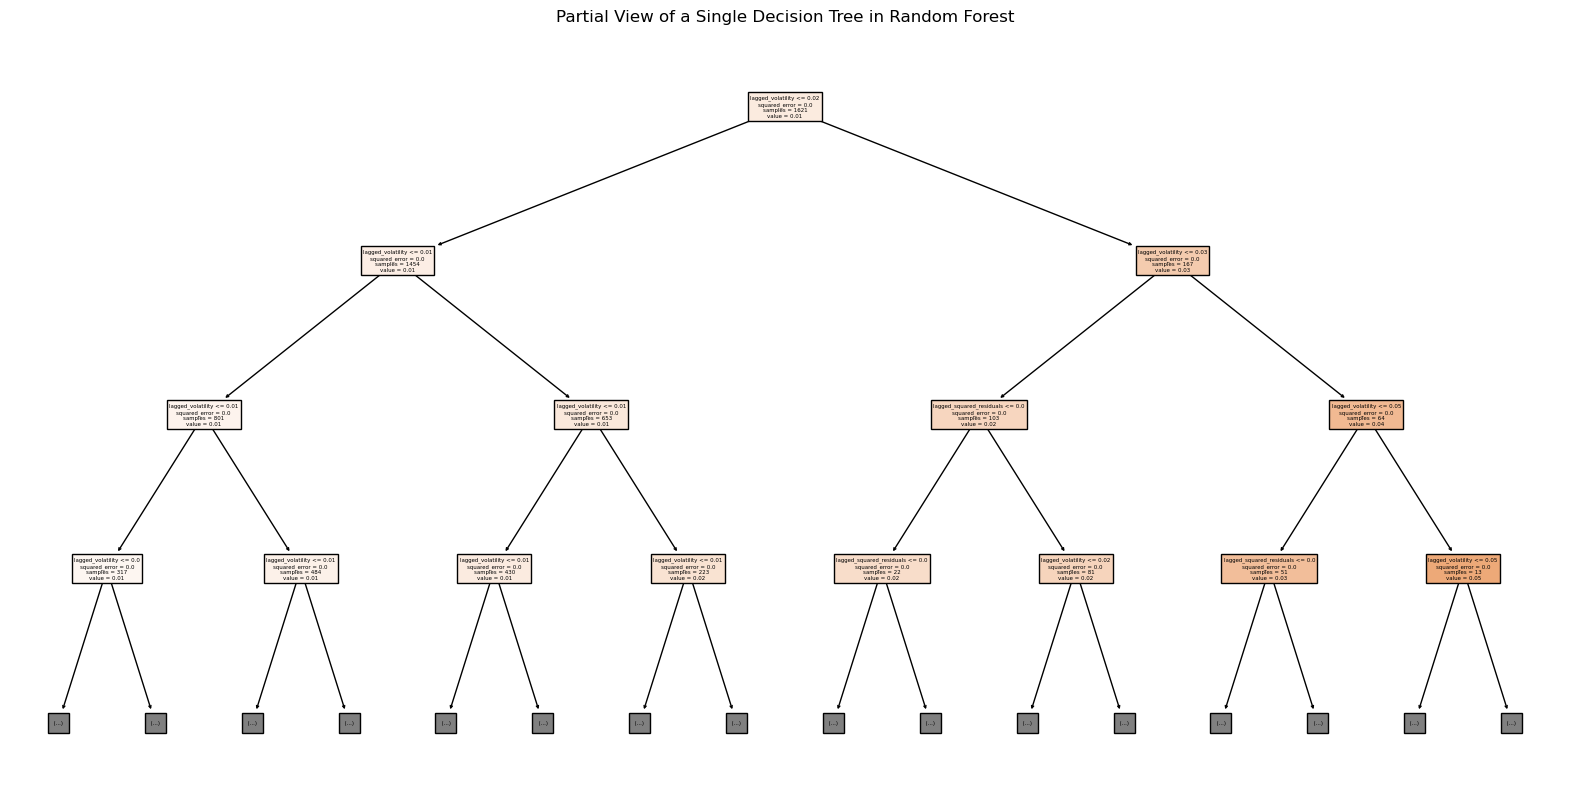

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.tree import plot_tree

# Example data simulation
# np.random.seed(0)
# SSE = pd.DataFrame(data={'Adj Close': np.random.randn(100).cumsum()})

# Calculate returns
ret = SSE['Adj Close'].pct_change().dropna()

# Calculate realized volatility and squared residuals
realized_vol = ret.rolling(5).std().dropna()
residuals = ret - ret.rolling(window=5).mean()
squared_residuals = residuals**2

# Prepare features
X = pd.DataFrame({
    'lagged_volatility': realized_vol.shift(1),
    'lagged_squared_residuals': squared_residuals.shift(1)
}).dropna()

# Prepare target
y = realized_vol.reindex(X.index)  # Ensure y is aligned with X

# Split data into training and testing
n = int(len(X) * 0.2)
X_train, X_test = X[:-n], X[-n:]
y_train, y_test = y[:-n], y[-n:]

# Define and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape * 100:.2f}%')

# Plotting Predicted vs Actual Volatility
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Volatility', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Volatility - RF', color='orange')
plt.title('Actual vs Predicted Volatility with RF model')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Feature importance visualization
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 4))
plt.title('Feature Importances in RF Model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Visualizing one of the trees
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, feature_names=X.columns, max_depth=3, precision=2)
plt.title("Partial View of a Single Decision Tree in Random Forest")
plt.show()


In [87]:
# Extracting and printing Random Forest feature importance
importances_rf = rf.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_rf})
print("Feature Importance from Random Forest:")
print(importance_df_rf.sort_values(by='Importance', ascending=False))

# Calculating and printing SVR feature importance
perm_importance_svr = permutation_importance(clf.best_estimator_, X_test, y_test, n_repeats=10, random_state=42)
importance_df_svr = pd.DataFrame({'Feature': X_train.columns, 'Importance': perm_importance_svr.importances_mean})
print("Permutation Importance from SVR:")
print(importance_df_svr.sort_values(by='Importance', ascending=False))

Feature Importance from Random Forest:
                    Feature  Importance
0         lagged_volatility    0.899161
1  lagged_squared_residuals    0.100839
Permutation Importance from SVR:
                    Feature  Importance
0         lagged_volatility    0.589689
1  lagged_squared_residuals    0.212264


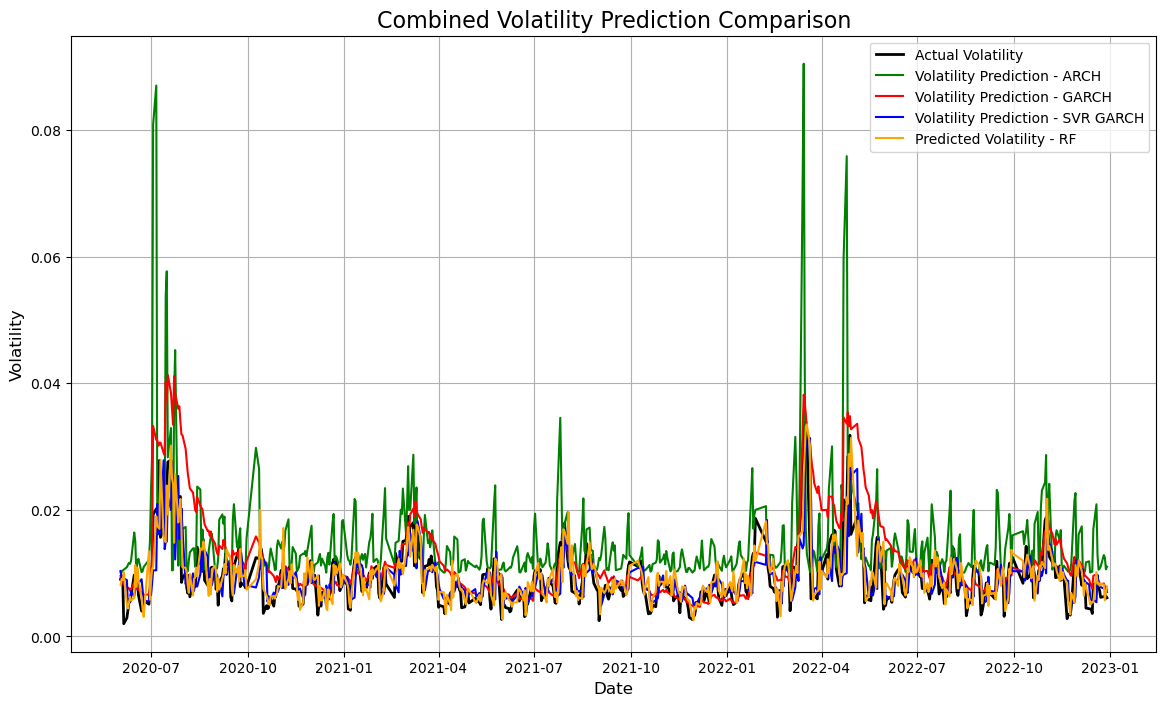

In [93]:
# Assuming the forecasts are pandas DataFrames with the same indexing as your test data
# and that the forecast outputs contain a column for the predicted variance

# Correctly slicing the forecast variance for the test period
forecast_arch_test = forecast_arch.variance.iloc[-len(y_test):] / 100
forecast_garch_test = forecast_garch.variance.iloc[-len(y_test):] / 100

plt.figure(figsize=(14, 8))

# Plot actual volatility
plt.plot(y_test.index, y_test / 100, label='Actual Volatility', color='black', linewidth=2)

# Plot ARCH model predictions
plt.plot(y_test.index, forecast_arch_test, label='Volatility Prediction - ARCH', color='green')

# Plot GARCH model predictions
plt.plot(y_test.index, forecast_garch_test, label='Volatility Prediction - GARCH', color='red')

# Plot SVR-GARCH predictions
plt.plot(y_test.index, pd.Series(predict_svr_rbf, index=y_test.index) / 100, label='Volatility Prediction - SVR GARCH', color='blue')

# Plot Random Forest predictions
plt.plot(y_test.index, y_pred, label='Predicted Volatility - RF', color='orange')

# Enhancing the plot
plt.title('Combined Volatility Prediction Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
